# Workplace Diversity Analysis

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

%matplotlib inline

# Load Dataset

In [2]:
company = pd.read_csv('company_hierarchy.csv')
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [3]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
employee_id    10000 non-null int64
boss_id        9999 non-null float64
dept           10000 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
employee = pd.read_csv('employee.csv')
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [5]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
employee_id       10000 non-null int64
signing_bonus     10000 non-null int64
salary            10000 non-null float64
degree_level      10000 non-null object
sex               10000 non-null object
yrs_experience    10000 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


In [ ]:
# employee.describe()

In [7]:
# merge employee and company information
data = pd.merge(left=employee, right=company, on='employee_id')
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


# Question 1

In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

-Individual Contributors (IC) - they don't manage anyone

-Middle Managers (MM) - they are the direct bosses of IC

-Directors (D) - they are the direct bosses of MM

-VP - D direct bosses

-Executives (E) - VP direct bosses

-CEO - The direct boss of E.

In [8]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
data.loc[data['dept'] == 'CEO', 'level'] = 'CEO'

for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i + 1]
    boss_id = data[data['level'] == boss_level]['employee_id']
    data.loc[data['boss_id'].isin(boss_id), 'level'] = empl_level

In [9]:
data[['employee_id', 'level']].sample(10)

,employee_id,level
58,198020,IC
6871,1133,IC
2101,134658,MM
5613,84909,IC
3192,59939,MM
1823,44967,IC
9920,157609,IC
5551,26989,IC
7287,99680,IC
1154,20898,IC


In [10]:
data

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC
...,...,...,...,...,...,...,...,...,...
9995,55261,0,307000.0,Bachelor,M,4,81111.0,engineering,IC
9996,84604,0,302000.0,PhD,M,6,83032.0,marketing,IC
9997,193115,1,132000.0,Bachelor,M,4,8663.0,sales,IC
9998,14249,0,77000.0,PhD,M,4,121527.0,marketing,IC


In [11]:
# value counts for each group
data['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

# Question 2

How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [12]:
# find the managed employees for each employee
data['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = data[data['level'] == level]['boss_id']
    employee_ids = data[data['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + data.loc[data['employee_id'] == e_id, 'counts'])
        b_counts = int(data.loc[data['employee_id'] == b_id, 'counts'])
        data.loc[data['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [13]:
data[['employee_id', 'level', 'counts']].sample(20)

,employee_id,level,counts
4681,86864,IC,0
2270,182928,IC,0
323,104365,IC,0
4094,108356,IC,0
3192,59939,MM,10
2668,144211,MM,8
4293,190566,MM,13
9671,87649,IC,0
4612,83007,IC,0
9672,127503,IC,0


# Question 3

Build a model to predict the salary of each employee.

In [14]:
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


### Visualization

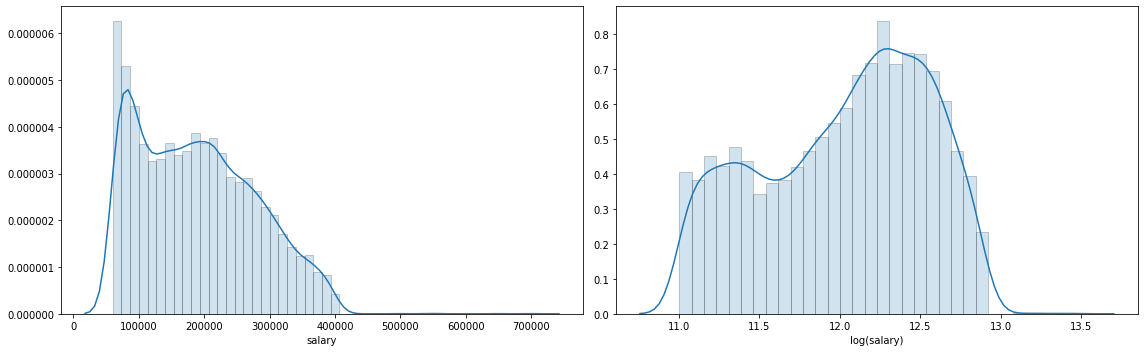

In [15]:
# Distribution of salary
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(data['salary'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(data['salary']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(salary)')
plt.tight_layout()
plt.show()

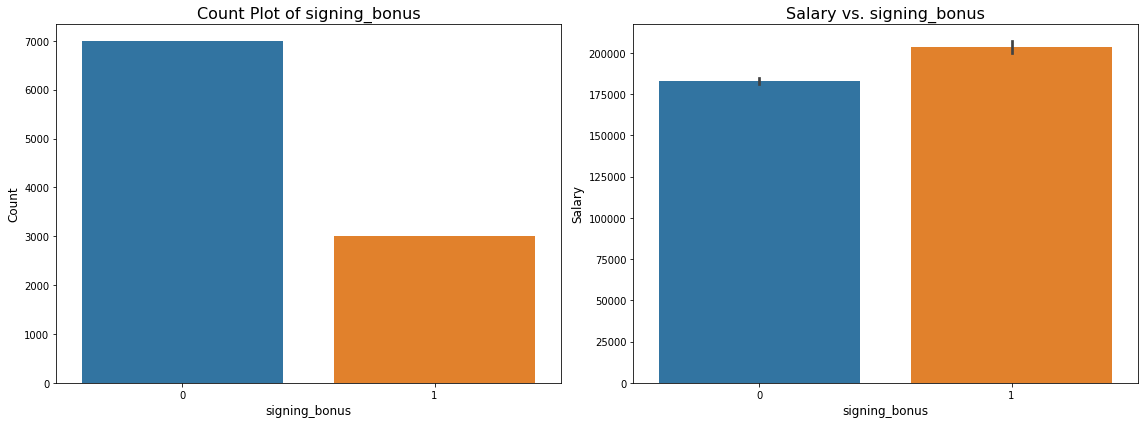

In [16]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='signing_bonus', data=data, ax=ax[0])
ax[0].set_xlabel('signing_bonus', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of signing_bonus', fontsize=16)

sns.barplot(x='signing_bonus', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('signing_bonus', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. signing_bonus', fontsize=16)
plt.tight_layout()
plt.show()

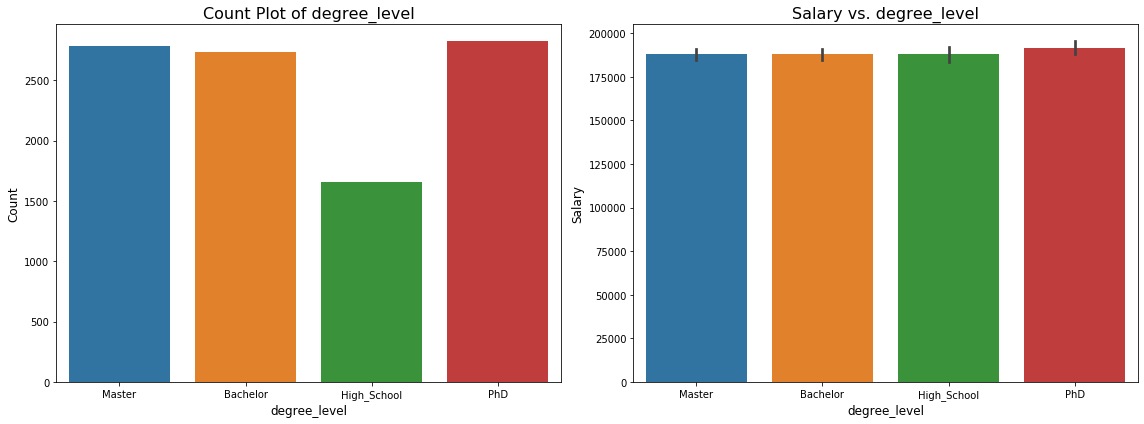

In [17]:
# visualization of 'degree_level'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='degree_level', data=data, ax=ax[0])
ax[0].set_xlabel('degree_level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of degree_level', fontsize=16)

sns.barplot(x='degree_level', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('degree_level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. degree_level', fontsize=16)
plt.tight_layout()
plt.show()

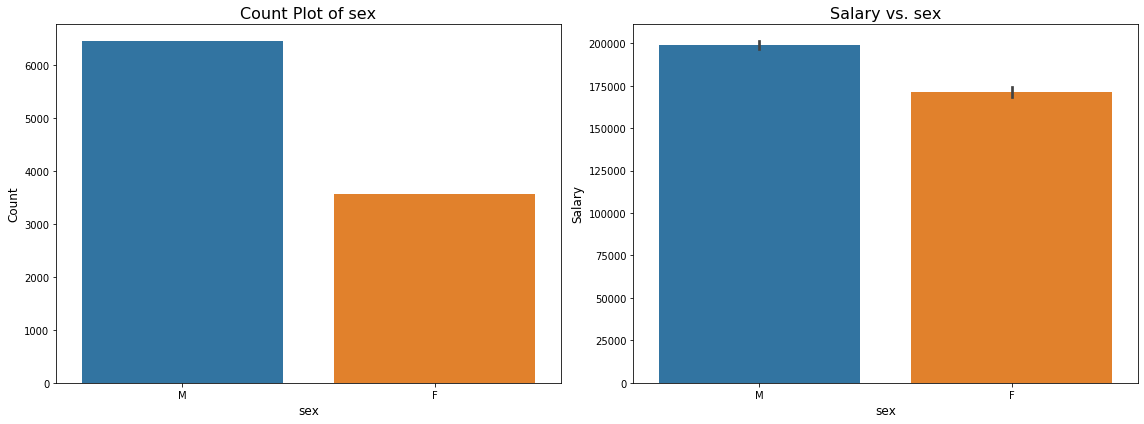

In [18]:
# visualization of 'sex'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_xlabel('sex', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('sex', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. sex', fontsize=16)
plt.tight_layout()
plt.show()

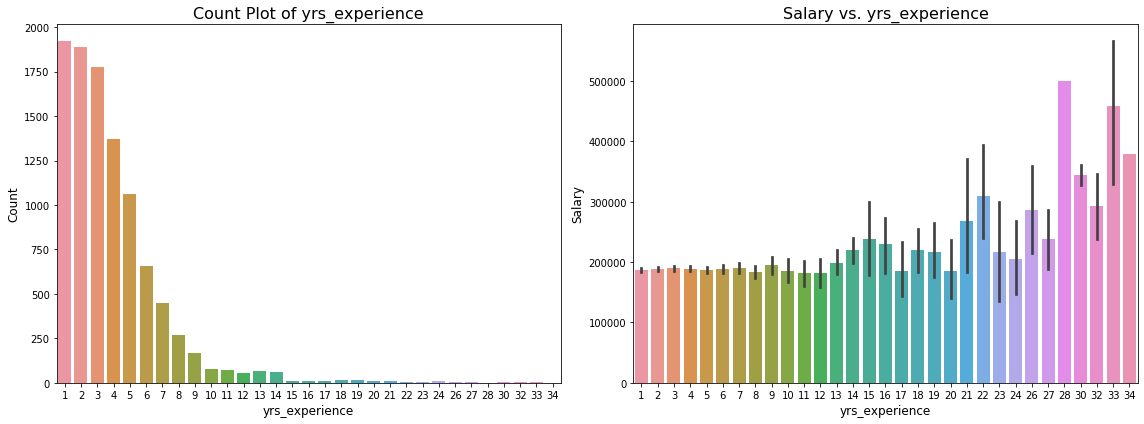

In [19]:
# visualization of 'yrs_experience'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='yrs_experience', data=data, ax=ax[0])
ax[0].set_xlabel('yrs_experience', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of yrs_experience', fontsize=16)

sns.barplot(x='yrs_experience', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('yrs_experience', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. yrs_experience', fontsize=16)
plt.tight_layout()
plt.show()

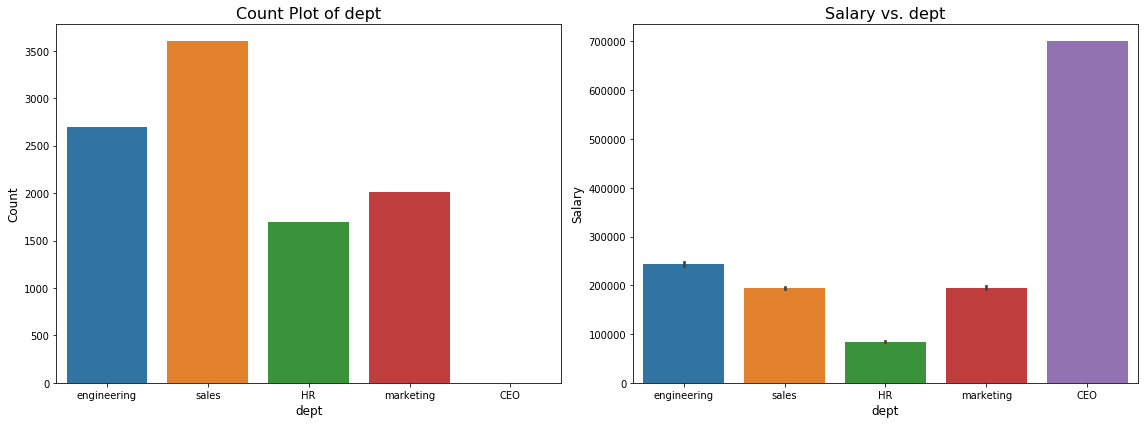

In [20]:
# visualization of 'dept'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dept', data=data, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.barplot(x='dept', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. dept', fontsize=16)
plt.tight_layout()
plt.show()

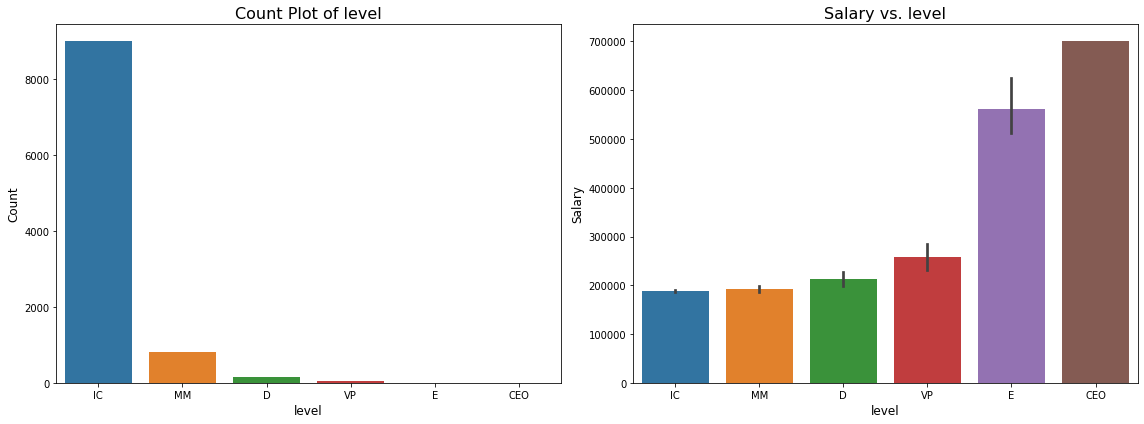

In [21]:
# visualization of 'levels'
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='level', data=data, ax=ax[0], order=orders)
ax[0].set_xlabel('level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of level', fontsize=16)

sns.barplot(x='level', y='salary', data=data, ax=ax[1], order=orders)
ax[1].set_xlabel('level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. level', fontsize=16)
plt.tight_layout()
plt.show()


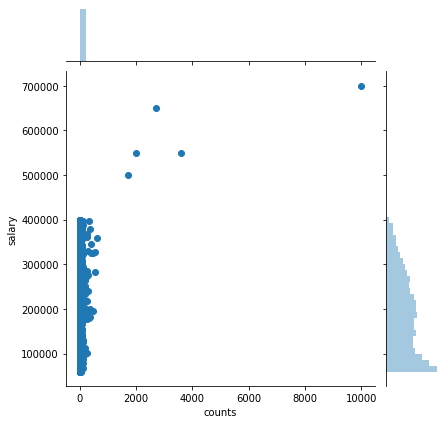

In [22]:
sns.jointplot(x='counts', y='salary', data=data, kind='scatter', size=6)
plt.show()

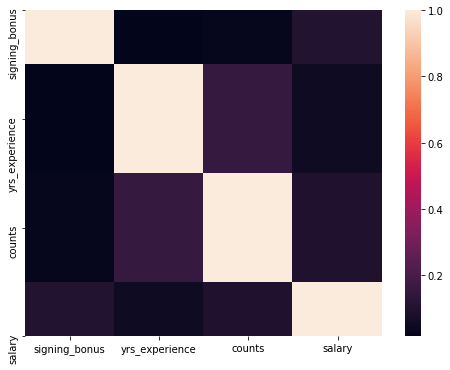

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
subset = data[['signing_bonus', 'yrs_experience', 'counts', 'salary']]
sns.heatmap(subset.corr(), ax=ax)
plt.show()

### Build Machine Learning Models with LightGBM

In [24]:
# Drop CEO department
data = data[data['dept'] != 'CEO']

# drop useless features
data = data.drop(labels=['employee_id', 'boss_id', 'level', 'counts'], axis=1)

data.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept
0,0,273000.0,Master,M,2,engineering
1,0,301000.0,Bachelor,F,1,sales
2,0,261000.0,Master,F,2,sales
3,0,86000.0,High_School,F,4,HR
4,0,126000.0,Bachelor,F,3,sales


In [25]:
# encoding categorical data
data['sex'] = (data['sex'] == 'M').astype(int)

degree_encoder = LabelEncoder()
data['degree_level'] = degree_encoder.fit_transform(data['degree_level'])

dept_encoder = LabelEncoder()
data['dept'] = dept_encoder.fit_transform(data['dept'])

In [26]:
# define categorical features
categorical_feature = ['signing_bonus', 'degree_level', 'sex', 'dept']
data[categorical_feature] = data[categorical_feature].astype('category')

In [27]:
# split into training and test data set
X = data.drop('salary', axis=1)
y = data['salary']

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.25, random_state=42)

# transform into log scale
y_train = np.log(y_train)
y_test = np.log(y_test)

In [28]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, 
                      categorical_feature=categorical_feature)

In [29]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, stratified=False)

best_round = len(history['rmse-mean'])
print('Best rounds:\t', best_round)

Best rounds:	 550


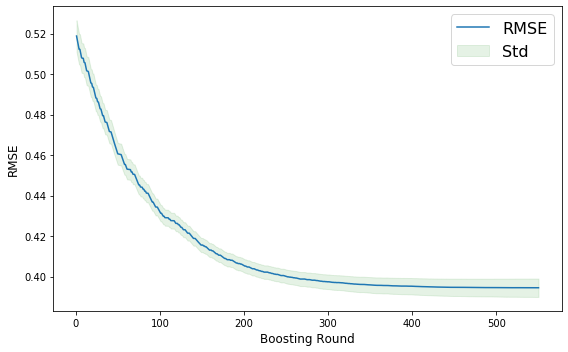

In [30]:
# visualization
rmse = np.array(history['rmse-mean'])
std = np.array(history['rmse-stdv'])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, best_round + 1), rmse, label='RMSE')
ax.fill_between(range(1, best_round + 1), rmse + std, rmse - std, 
                alpha=0.1, color='g', label='Std')
ax.set_xlabel('Boosting Round', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
# re-train the model and make predictions
clf = lgb.train(params, train_set=d_train, num_boost_round=best_round)
pred = clf.predict(X_test)

In [32]:
print('Test RMSE:\t', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R2:\t', r2_score(y_test, pred))

Test RMSE:	 0.39152740477439957
Test R2:	 0.39979721463855666


# Question 4

Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

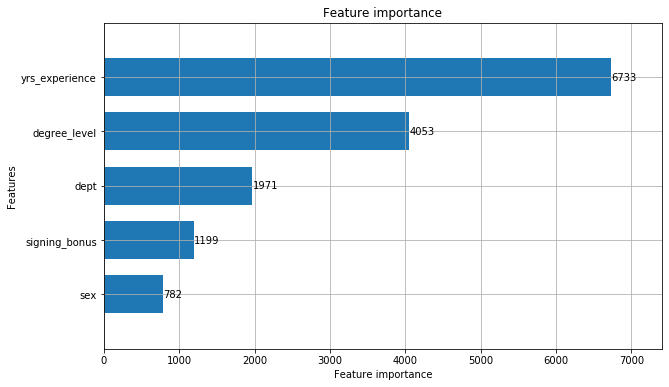

In [33]:
# feature importance
features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(clf, ax=ax, height=0.7)
plt.show()